# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

В первую очередь необходимо изучить данные: проверить на правильность, рассмотреть пропуски и аномальные значения, удалить ненужные признаки. Далее для моделей приготовим выборки, протестируем три модели: линейная регрессия, случайный лес и LightGBM. Проанализируем время работы каждой из моделей и по заданным критериям выберем лучшую.

## Подготовка данных

In [51]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OrdinalEncoder
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV
from sklearn.impute import KNNImputer

import warnings
warnings.filterwarnings("ignore")

In [52]:
try:
    data = pd.read_csv('/datasets/autos.csv')
except: 
    data = pd.read_csv('C:/Users/klimatutti/Downloads/autos.csv')

In [53]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

**В датафрейме 354 368 строк и 16 столбцов. Во многих важных признаках есть большое количество пропусков, которые необходимо изучить. Названия колонок записаны некорректно**

Переведем названия колонок в нижний регистр и между словами поставим подчеркивание.

In [54]:
data.columns = data.columns.str.replace(r"([A-Z])", r" \1").str.lower().str.replace(' ', '_').str[1:]

Ненужные признаки удалим.

In [55]:
data = data.drop(['number_of_pictures', 'postal_code', 'date_created', 'last_seen', 'registration_month', 'date_crawled'], axis=1)

In [56]:
data.head(5)

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired
0,480,NaN,1993,manual,0,golf,150000,petrol,volkswagen,NaN
1,18300,coupe,2011,manual,190,NaN,125000,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,NaN
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no


Таким образом, оставили следующие признаки: цена, тип кузова, год регистрации, тип коробки передач, мощность, модель, пробег, тип топлива, бренд и информация о ремонте.

Рассмотрим признаки с пропусками.

In [57]:
data.isna().sum()

price                    0
vehicle_type         37490
registration_year        0
gearbox              19833
power                    0
model                19705
kilometer                0
fuel_type            32895
brand                    0
repaired             71154
dtype: int64

In [58]:
data.loc[(data['vehicle_type'].isna()) & (data['gearbox'].isna()) & (data['model'].isna()) 
         & (data['fuel_type'].isna()) & (data['repaired'].isna())]

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired
306,200,NaN,2009,NaN,0,NaN,10000,NaN,sonstige_autos,NaN
522,0,NaN,2000,NaN,0,NaN,150000,NaN,volvo,NaN
538,2600,NaN,2005,NaN,0,NaN,125000,NaN,chevrolet,NaN
552,50,NaN,1985,NaN,0,NaN,150000,NaN,trabant,NaN
622,0,NaN,1111,NaN,0,NaN,5000,NaN,opel,NaN
...,...,...,...,...,...,...,...,...,...,...
353727,1,NaN,2000,NaN,0,NaN,150000,NaN,bmw,NaN
354073,1750,NaN,1995,NaN,0,NaN,100000,NaN,sonstige_autos,NaN
354083,0,NaN,2000,NaN,0,NaN,150000,NaN,sonstige_autos,NaN
354162,1500,NaN,1995,NaN,0,NaN,150000,NaN,volkswagen,NaN


Для начала удалим строки, в которых есть пропуски в каждом из столбцов.

In [59]:
data = data.dropna(subset=['vehicle_type', 'fuel_type', 'model', 'repaired','gearbox'], how='all') 

Рассмотрим пропуски отдельно в каждом столбце

In [61]:
data['vehicle_type'].unique()

array([nan, 'coupe', 'suv', 'small', 'sedan', 'convertible', 'bus',
       'wagon', 'other'], dtype=object)

В столбце `vehicle_type` заменим пропуски на `other`

In [62]:
data['vehicle_type'] = data['vehicle_type'].fillna('other')

In [63]:
data['fuel_type'].unique()

array(['petrol', 'gasoline', nan, 'lpg', 'other', 'hybrid', 'cng',
       'electric'], dtype=object)

Также поступим с `fuel_type` и `model`

In [64]:
data['fuel_type'] = data['fuel_type'].fillna('other')

In [66]:
data['model'].unique()

array(['golf', nan, 'grand', 'fabia', '3er', '2_reihe', 'other', 'c_max',
       '3_reihe', 'passat', 'navara', 'ka', 'polo', 'twingo', 'a_klasse',
       'scirocco', '5er', 'meriva', 'arosa', 'c4', 'civic', 'transporter',
       'punto', 'e_klasse', 'clio', 'kadett', 'kangoo', 'corsa', 'one',
       'fortwo', '1er', 'b_klasse', 'signum', 'astra', 'a8', 'jetta',
       'fiesta', 'c_klasse', 'micra', 'vito', 'sprinter', '156', 'escort',
       'forester', 'xc_reihe', 'scenic', 'a4', 'a1', 'insignia', 'combo',
       'focus', 'tt', 'a6', 'jazz', 'omega', 'slk', '7er', '80', '147',
       '100', 'z_reihe', 'sportage', 'sorento', 'v40', 'ibiza', 'mustang',
       'eos', 'touran', 'getz', 'a3', 'almera', 'megane', 'lupo', 'r19',
       'zafira', 'caddy', 'mondeo', 'cordoba', 'colt', 'impreza',
       'vectra', 'berlingo', 'tiguan', 'i_reihe', 'espace', 'sharan',
       '6_reihe', 'panda', 'up', 'seicento', 'ceed', '5_reihe', 'yeti',
       'octavia', 'mii', 'rx_reihe', '6er', 'modus', 'fox'

In [67]:
data['model'] = data['model'].fillna('other')

In [68]:
data['gearbox'].unique()

array(['manual', 'auto', nan], dtype=object)

Пропуски в `gearbox` заменим на `unknown`

In [69]:
data['gearbox'] = data['gearbox'].fillna('unknown')

In [70]:
data['repaired'].unique()

array([nan, 'yes', 'no'], dtype=object)

Пропуски в `repaired` заменим на `no`

In [71]:
data['repaired'] = data['repaired'].fillna('no')

In [72]:
data.isna().sum()

price                0
vehicle_type         0
registration_year    0
gearbox              0
power                0
model                0
kilometer            0
fuel_type            0
brand                0
repaired             0
dtype: int64

**Подробнее изучим данные**

In [73]:
data.describe()

,price,registration_year,power,kilometer
count,352132.000000,352132.000000,352132.000000,352132.000000
mean,4437.540570,2003.871636,110.720108,128438.071519
std,4516.540446,70.673430,190.249667,37562.896848
min,0.000000,1000.000000,0.000000,5000.000000
25%,1100.000000,1999.000000,69.000000,125000.000000
50%,2750.000000,2003.000000,105.000000,150000.000000
75%,6450.000000,2008.000000,143.000000,150000.000000
max,20000.000000,9999.000000,20000.000000,150000.000000


Видим, что у `price` минимальное значение - **0**, чего быть не должно. Максимальный год регистрации - **9999**, что явно говорит об ошибке в данных. У мощности минимальное значение - **0**. Всё это выбросы, которые нужно удалить.

Значения цены рассмотрим на "ящике с усами"

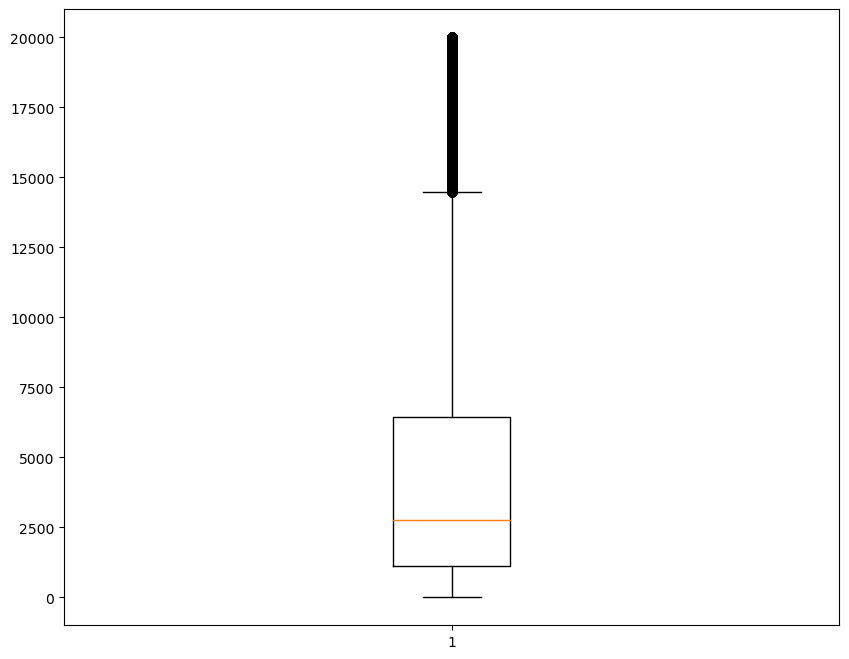

In [74]:
plt.figure(figsize=(10, 8))
plt.boxplot(x=data['price']);

Установим то, что цена не может быть меньше 200 долларов.

In [75]:
data = data.loc[data['price'] > 200]

Далее рассмотрим года регистрации

In [76]:
data['registration_year'].unique()

array([1993, 2011, 2004, 2001, 2008, 1995, 2014, 1998, 2005, 1910, 2016,
       2007, 2009, 2002, 2018, 1997, 1990, 2017, 1981, 2003, 1994, 1991,
       1984, 2006, 1999, 2012, 2010, 2000, 1992, 2013, 1996, 1989, 2015,
       1985, 1982, 1976, 1983, 1973, 1969, 1971, 1987, 1988, 1980, 1986,
       1965, 1970, 1945, 1925, 1974, 1979, 1955, 1978, 1972, 1968, 1977,
       1961, 1966, 1975, 1963, 1964, 1960, 1958, 1967, 1956, 1941, 9999,
       1500, 2200, 1962, 1929, 1957, 1940, 2066, 1949, 2019, 1937, 1951,
       1800, 1959, 1953, 1954, 9000, 2900, 6000, 1000, 5911, 1400, 5000,
       4000, 1948, 1952, 8500, 1932, 1950, 3700, 4800, 1942, 1935, 1933,
       1936, 1923, 2290, 1930, 1001, 1234, 9450, 1944, 7000, 2500, 1943,
       1938, 1934, 1928, 5555, 1039, 3000, 2800, 1931, 4500, 1602, 7800,
       1947, 1927, 7100, 1300, 8200, 1946, 1600], dtype=int64)

Вспомним, что самая свежая информация в датасете - это 2016 год, значит всё, что больше - это ошибка, а также удалим машины старше 1970 года.

In [77]:
data = data.loc[(data['registration_year'] < 2016) & (data['registration_year'] > 1970)]

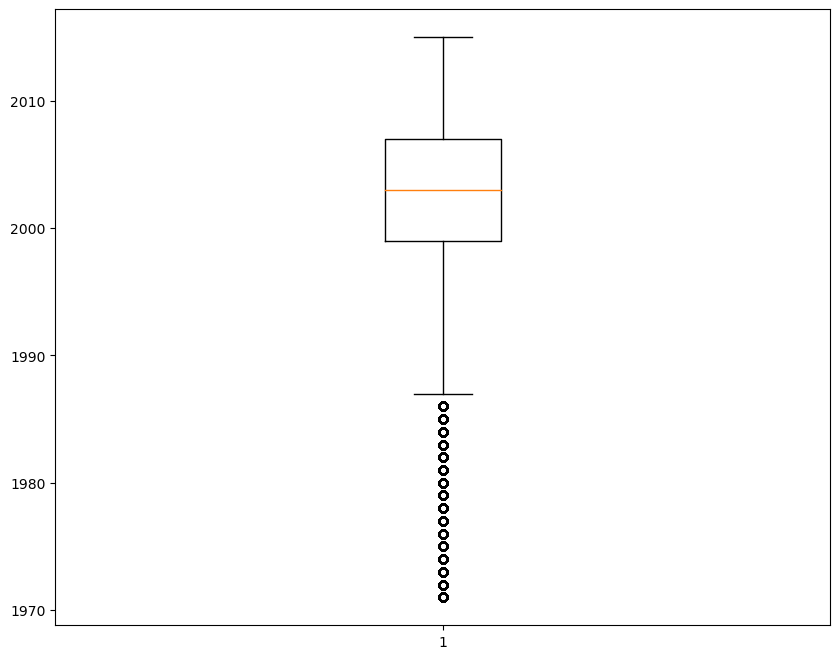

In [78]:
plt.figure(figsize=(10, 8))
plt.boxplot(x=data['registration_year']);

Далее мощность

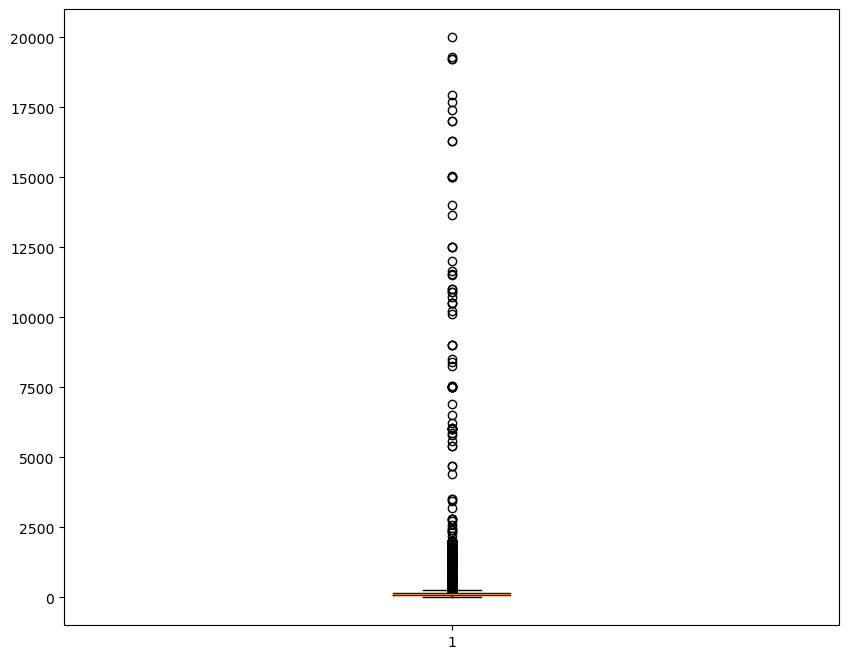

In [79]:
plt.figure(figsize=(10, 8))
plt.boxplot(x=data['power']);

Установим минимальную мощность - **10**, а максимальную - **1000**

In [80]:
data = data.loc[(data['power'] >= 10) & (data['power'] <= 1000)]

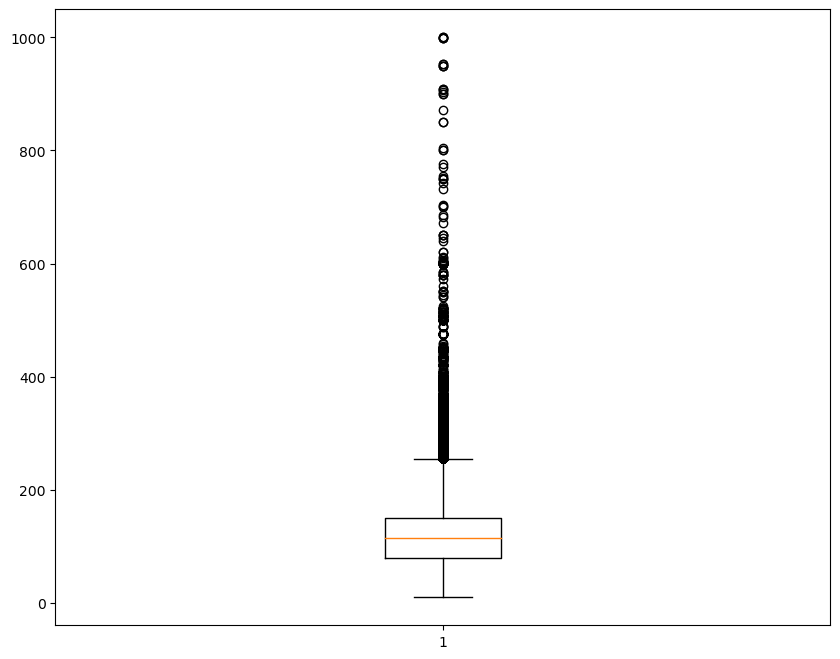

In [81]:
plt.figure(figsize=(10, 8))
plt.boxplot(x=data['power']);

In [82]:
data.describe()

,price,registration_year,power,kilometer
count,284310.000000,284310.000000,284310.000000,284310.000000
mean,4975.488534,2002.735261,121.961264,128210.580001
std,4612.381865,5.927522,54.492981,36609.544887
min,202.000000,1971.000000,10.000000,5000.000000
25%,1450.000000,1999.000000,80.000000,125000.000000
50%,3300.000000,2003.000000,115.000000,150000.000000
75%,7100.000000,2007.000000,150.000000,150000.000000
max,20000.000000,2015.000000,1000.000000,150000.000000


**С выбросами разобрались**

Удалим дубликаты

In [83]:
data.duplicated().sum()

44378

In [84]:
data = data.drop_duplicates().reset_index(drop=True)
data.duplicated().sum()

0

### Вывод

В данном датафреме были исправлены названия столбцов, изучены и исправлены пропуски и выбросы в значениях, а также удалены дубликаты.

## Обучение моделей

Для начала закодируем категориальные признаки с помощью `get_dummies`

In [85]:
data_ohe = pd.get_dummies(data, drop_first=True)
data_ohe.head()

,price,registration_year,power,kilometer,vehicle_type_convertible,vehicle_type_coupe,vehicle_type_other,vehicle_type_sedan,vehicle_type_small,vehicle_type_suv,...,brand_skoda,brand_smart,brand_sonstige_autos,brand_subaru,brand_suzuki,brand_toyota,brand_trabant,brand_volkswagen,brand_volvo,repaired_yes
0,18300,2011,190,125000,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,9800,2004,163,125000,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,1500,2001,75,150000,0,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
3,3600,2008,69,90000,0,0,0,0,1,0,...,1,0,0,0,0,0,0,0,0,0
4,650,1995,102,150000,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1


Выделим признаки и целевой признак, а также разделим данные на обучающую и тестовую выборки

In [86]:
target_ohe = data_ohe['price']
features_ohe = data_ohe.drop('price', axis=1)
features_train_ohe, features_test_ohe, target_train_ohe, target_test_ohe = train_test_split(features_ohe, target_ohe, test_size=0.25, random_state=12345) 
print(features_train_ohe.shape)
print(features_test_ohe.shape)

(179949, 306)
(59983, 306)


Для будущего масштабирования подготовим список количественных данных

In [87]:
numeric = list(data_ohe)
numeric.remove('price')
numeric

['registration_year',
 'power',
 'kilometer',
 'vehicle_type_convertible',
 'vehicle_type_coupe',
 'vehicle_type_other',
 'vehicle_type_sedan',
 'vehicle_type_small',
 'vehicle_type_suv',
 'vehicle_type_wagon',
 'gearbox_manual',
 'gearbox_unknown',
 'model_145',
 'model_147',
 'model_156',
 'model_159',
 'model_1_reihe',
 'model_1er',
 'model_200',
 'model_2_reihe',
 'model_300c',
 'model_3_reihe',
 'model_3er',
 'model_4_reihe',
 'model_500',
 'model_5_reihe',
 'model_5er',
 'model_601',
 'model_6_reihe',
 'model_6er',
 'model_7er',
 'model_80',
 'model_850',
 'model_90',
 'model_900',
 'model_9000',
 'model_911',
 'model_a1',
 'model_a2',
 'model_a3',
 'model_a4',
 'model_a5',
 'model_a6',
 'model_a8',
 'model_a_klasse',
 'model_accord',
 'model_agila',
 'model_alhambra',
 'model_almera',
 'model_altea',
 'model_amarok',
 'model_antara',
 'model_arosa',
 'model_astra',
 'model_auris',
 'model_avensis',
 'model_aveo',
 'model_aygo',
 'model_b_klasse',
 'model_b_max',
 'model_beetle',

Для масштабирования данных применим `StandardScaler`

In [88]:
scaler = StandardScaler()
scaler.fit(features_train_ohe[numeric])
features_train_ohe[numeric] = scaler.transform(features_train_ohe[numeric])
features_test_ohe[numeric] = scaler.transform(features_test_ohe[numeric])

In [89]:
features_train_ohe.head()

,registration_year,power,kilometer,vehicle_type_convertible,vehicle_type_coupe,vehicle_type_other,vehicle_type_sedan,vehicle_type_small,vehicle_type_suv,vehicle_type_wagon,...,brand_skoda,brand_smart,brand_sonstige_autos,brand_subaru,brand_suzuki,brand_toyota,brand_trabant,brand_volkswagen,brand_volvo,repaired_yes
224692,-2.114557,0.485597,0.619508,-0.270711,-0.235978,-0.163012,1.586928,-0.542579,-0.20408,-0.508428,...,-0.135195,-0.129367,-0.076537,-0.048252,-0.084006,-0.124323,-0.030295,-0.504296,-0.100772,-0.333201
45401,-0.794621,-0.241113,0.619508,-0.270711,-0.235978,-0.163012,1.586928,-0.542579,-0.20408,-0.508428,...,-0.135195,-0.129367,-0.076537,-0.048252,-0.084006,-0.124323,-0.030295,-0.504296,-0.100772,-0.333201
178267,1.020291,-0.023100,-1.777718,-0.270711,-0.235978,-0.163012,1.586928,-0.542579,-0.20408,-0.508428,...,-0.135195,-0.129367,-0.076537,-0.048252,-0.084006,-0.124323,-0.030295,1.982962,-0.100772,-0.333201
164028,0.690307,-1.240340,0.619508,-0.270711,-0.235978,-0.163012,-0.630148,1.843049,-0.20408,-0.508428,...,-0.135195,-0.129367,-0.076537,-0.048252,-0.084006,-0.124323,-0.030295,1.982962,-0.100772,-0.333201
89562,0.690307,1.103301,-0.712284,-0.270711,-0.235978,-0.163012,1.586928,-0.542579,-0.20408,-0.508428,...,-0.135195,-0.129367,-0.076537,-0.048252,-0.084006,-0.124323,-0.030295,-0.504296,-0.100772,-0.333201


### Линейная регрессия

Подбор модели начнем с линейной регрессии. Обучим модель на обучающей выборке, найдем предсказания и rmse

In [90]:
def rmse_count(target, predictions):
    return mean_squared_error(target, predictions)**0.5

In [92]:
model = LinearRegression()
model.fit(features_train_ohe, target_train_ohe)
predictions = model.predict(features_test_ohe)
rmse_count(target_test_ohe, predictions)

2536.2103761141348

Для следующей модели закодируем признаки с помощью порядкового кодирования

Разделим признаки

In [93]:
target_oe = data['price']
features_oe = data.drop('price', axis=1)
features_train_oe, features_test_oe, target_train_oe, target_test_oe = train_test_split(features_oe, target_oe, 
                                                                                        test_size=0.25, random_state=12345) 

print(features_train_oe.shape)
print(features_test_oe.shape)

(179949, 9)
(59983, 9)


In [94]:
oencoder = OrdinalEncoder()
features_train_oe = oencoder.fit_transform(features_train_oe)
features_test_oe = oencoder.transform(features_test_oe)

### Случайный лес

In [96]:
%%time
for est in [100, 500, 1000]:
    model = RandomForestRegressor(random_state=12345, n_estimators=est, max_depth=9)
    model.fit(features_train_oe, target_train_oe)
    predictions = model.predict(features_test_oe)
    rmse = rmse_count(target_test_oe, predictions)
    print('Количество деревьев:', est)
    print('RMSE для случайного леса:', rmse)
    print('')
print()

Количество деревьев: 100
RMSE для случайного леса: 2024.9343028348883

Количество деревьев: 500
RMSE для случайного леса: 2022.3422088212299

Количество деревьев: 1000
RMSE для случайного леса: 2022.0324232823855


Wall time: 17min 22s


Лучший результат показало 1000 деревьев - 2022

### LightGBM

Для следующей модели необходимо перевести категориальные признаки в тип `category`

In [97]:
target = data['price']
features = data.drop('price', axis=1)

for c in features.columns:
    col_type = features[c].dtype
    if col_type == 'object':
        features[c] = features[c].astype('category')

features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.25, random_state=12345) 

print(features_train.shape)
print(features_test.shape)

(179949, 9)
(59983, 9)


In [99]:
param_grid = {'n_estimators': [100, 200, 300], 'num_leaves': [7, 15, 31]}

In [100]:
model = lgb.LGBMRegressor(random_state=12345)

tuning_model=GridSearchCV(estimator=model, param_grid=param_grid, scoring='neg_root_mean_squared_error', cv=3, verbose=3)

tuning_model.fit(features_train, target_train)
display(tuning_model.best_params_)
display(tuning_model.best_score_*-1)

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 1/3] END n_estimators=100, num_leaves=7;, score=-1737.712 total time=   1.3s
[CV 2/3] END n_estimators=100, num_leaves=7;, score=-1749.052 total time=   1.2s
[CV 3/3] END n_estimators=100, num_leaves=7;, score=-1763.219 total time=   1.2s
[CV 1/3] END n_estimators=100, num_leaves=15;, score=-1669.687 total time=   1.5s
[CV 2/3] END n_estimators=100, num_leaves=15;, score=-1663.150 total time=   1.7s
[CV 3/3] END n_estimators=100, num_leaves=15;, score=-1682.164 total time=   1.6s
[CV 1/3] END n_estimators=100, num_leaves=31;, score=-1627.529 total time=   2.6s
[CV 2/3] END n_estimators=100, num_leaves=31;, score=-1615.163 total time=   1.8s
[CV 3/3] END n_estimators=100, num_leaves=31;, score=-1636.740 total time=   1.8s
[CV 1/3] END n_estimators=200, num_leaves=7;, score=-1687.400 total time=   1.9s
[CV 2/3] END n_estimators=200, num_leaves=7;, score=-1689.328 total time=   2.0s
[CV 3/3] END n_estimators=200, num_leaves=7

{'n_estimators': 300, 'num_leaves': 31}

1590.640972200553

Протестируем модель на тестоовй выборке

In [101]:
model = lgb.LGBMRegressor(random_state=12345, n_estimators=300, num_leaves=31)
model.fit(features_train, target_train)
predictions = model.predict(features_test)
rmse_count(target_test, predictions)

1566.5763086683214

Результат модели 1567

### Вывод

Были обучени и протестированы три модели: линейная регрессия, случайный лес и lightGBM. Лучший результат rmse показала модель lightGBM 1567

## Анализ моделей

Для каждой модели найдем время обучения и предсказания

In [102]:
%%time

model_lr = LinearRegression()
model_lr.fit(features_train_ohe, target_train_ohe)

Wall time: 8.39 s


LinearRegression()

In [103]:
%%time

predictions_train_ohe = model_lr.predict(features_test_ohe)

Wall time: 64 ms


In [104]:
%%time

model_rf = RandomForestRegressor(random_state=12345, max_depth=9, n_estimators=1000)
model_rf.fit(features_train_oe, target_train_oe)

Wall time: 10min 27s


RandomForestRegressor(max_depth=9, n_estimators=1000, random_state=12345)

In [105]:
%%time

predictions_train_oe = model_rf.predict(features_test_oe)

Wall time: 11.3 s


In [106]:
%%time
model_lgb = lgb.LGBMRegressor(random_state=12345, n_estimators=300, num_leaves=31)
model_lgb.fit(features_train, target_train)

Wall time: 4.11 s


LGBMRegressor(n_estimators=300, random_state=12345)

In [107]:
%%time

predictions_train = model_lgb.predict(features_test)

Wall time: 2.04 s


In [108]:
tabledata = [["Linear Regression", "8.39 s", "64 ms", '2536.2103761141348'],
         ["Random Forest", "10min 27s", "11.3 s", '2022.0324232823855'],
         ["LightGBM", "4.11 s", "2.04 s", '1566.5763086683214']]
df= pd.DataFrame(tabledata, columns=["модель","Время обучения", "Время предсказания", 'RMSE'])
df = df.set_index('модель')
df.index.names = [None]
df

,Время обучения,Время предсказания,RMSE
Linear Regression,8.39 s,64 ms,2536.2103761141348
Random Forest,10min 27s,11.3 s,2022.0324232823855
LightGBM,4.11 s,2.04 s,1566.5763086683214


Критерии, которые важны заказчику:
- качество предсказания;
- время обучения модели;
- время предсказания модели.

Самой качественной моделью оказалась **LightGBM**

Самой быстрой в обучении моделью оказалась **LightGBM**

Самой быстрой в предсказании моделью оказалась **Linear Regression**

В двух из трёх пунктов лидирует модель LightGBM